In [1]:
import numpy as np
import cv2

In [2]:
import pandas as pd

In [3]:
import matplotlib.pyplot as plt

In [4]:
from os import walk

In [68]:
train_path = "./data/train_profile_images"

### Load images

In [72]:
def load_images(path): 
    file_names = []
    for (dirpath, dirnames, filenames) in walk(path):
        file_names = filenames
        break
    
    img_data = []
    img_ids = []
    for f in file_names:
        if f.lower().endswith(('.png')):
            img = cv2.cvtColor(cv2.imread(f"{path}/{f}"), cv2.COLOR_BGR2RGB)
            img_data.append(img)
            img_ids.append(f.split(".")[0])
    
    return np.array(img_data), np.array(img_ids)

In [73]:
raw_data, ids = load_images(train_path)
raw_data = raw_data+1
raw_data.shape, ids.shape

((2500, 32, 32, 3), (2500,))

### Preview sample images

In [8]:
def preview_samples(data, nrows=2, ncols=3, figsize=(8, 6), cmap=None, random_seed=34):
    np.random.seed(random_seed)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    for rows in axes:
        for ax in rows:
            idx = np.random.randint(data.shape[0])
            ax.imshow(data[idx], cmap=cmap)
            ax.set_title(f"sample #{idx}")

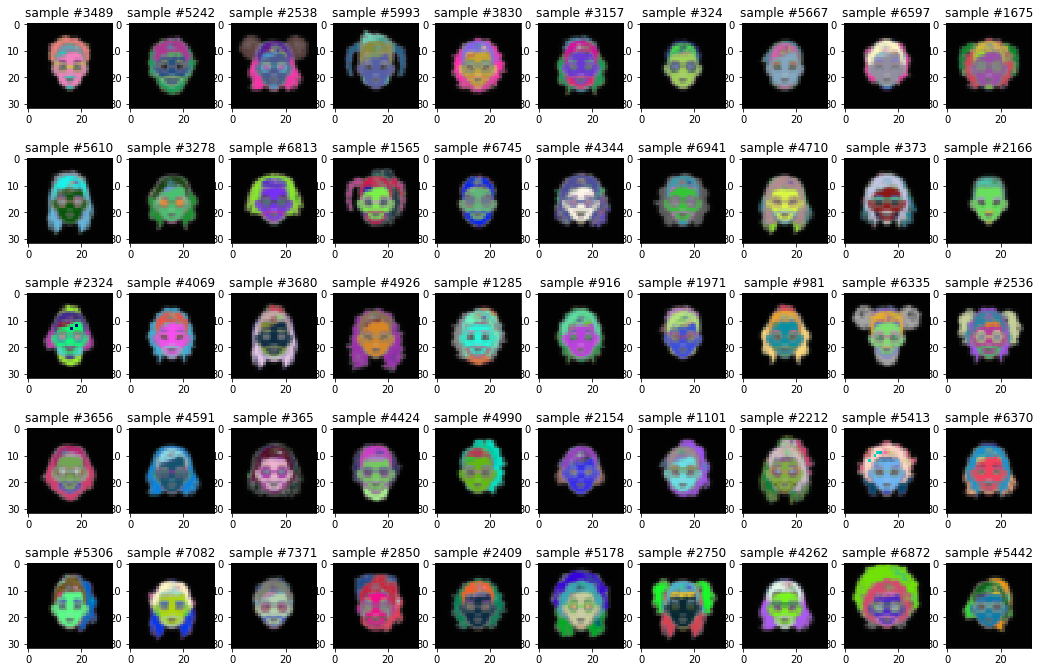

In [9]:
preview_samples(raw_data, nrows=5, ncols=10, figsize=(18, 12))

We observe from the above several images in the dataset are repeated with a change in color and some light modifications.

### Transform data

In this section, we will cluster the images based of the shape of the avatars. For this, we first covert to RGB images into a graycale format thus reducing the features size. Next, we compress the images to only keep the edges.

In [10]:
def detect_edges(data, algo="canny"):
    new_data = []
    for idx in range(data.shape[0]):
        if algo == 'laplacian':
            edges = cv2.cvtColor(data[idx], cv2.COLOR_RGB2GRAY)
        else:
            edges = cv2.Canny(data[idx], 10, 10)
        
        new_data.append(edges)
    
    return np.array(new_data)

In [11]:
edged_data = detect_edges(raw_data)
edged_data.shape

(7500, 32, 32)

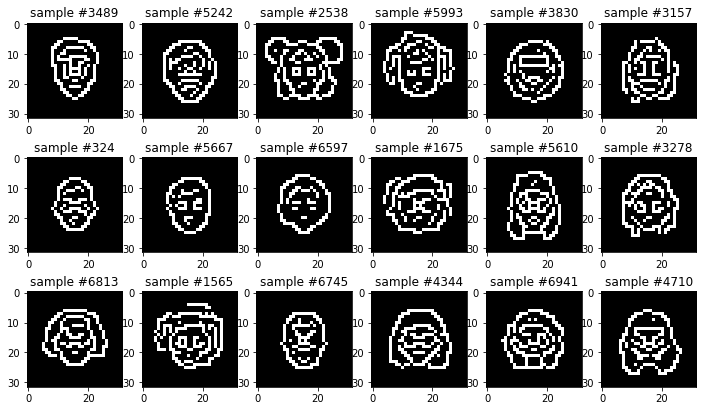

In [12]:
preview_samples(edged_data, nrows=3, ncols=6, figsize=(12, 7), cmap="binary_r")

# K-Means clustering

In [13]:
from sklearn.cluster import KMeans

In [17]:
def preview_classification(data, labels):
    for label in np.unique(labels):
        y = labels[labels == label]
        x = data[labels == label]

        print(label)
        fig, axes = plt.subplots(nrows=2, ncols=min(10, y.shape[0]), figsize=(18, 3))
        for row in axes:
            for ax in row:
                idx = np.random.randint(x.shape[0])
                ax.imshow(x[idx])
        plt.show()
        print()

### Cluster based on shape

In [77]:
def shape_clustering(data, n_classes):
    # Edge detection
    X = detect_edges(data)
    
    # Flatten images
    X = X.reshape((X.shape[0], -1))
    
    kmeans = KMeans(n_clusters=n_classes, n_init=20, n_jobs=-1)
    labels = kmeans.fit_predict(X)
    
    return np.array([f"class {y}" for y in labels])

In [32]:
category_labels = shape_clustering(raw_data, n_classes=18)

class 0


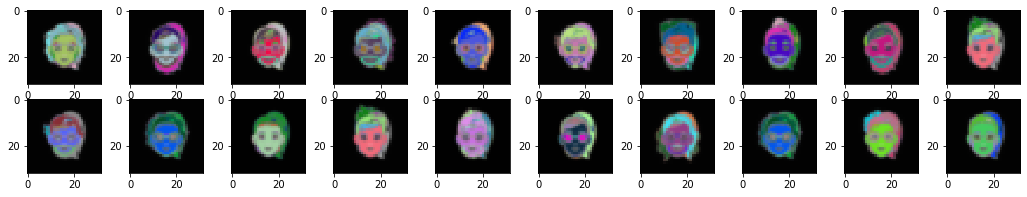


class 1


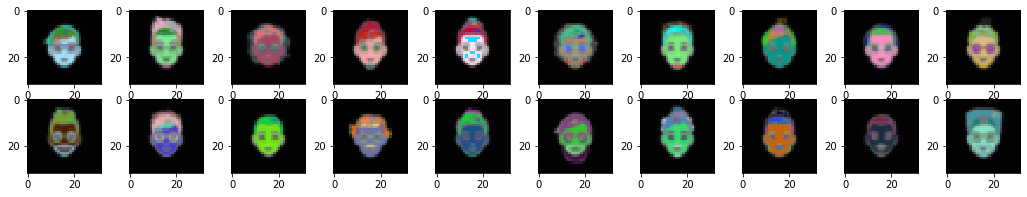


class 10


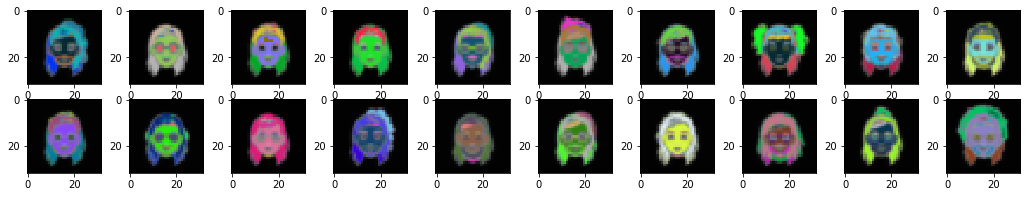


class 11


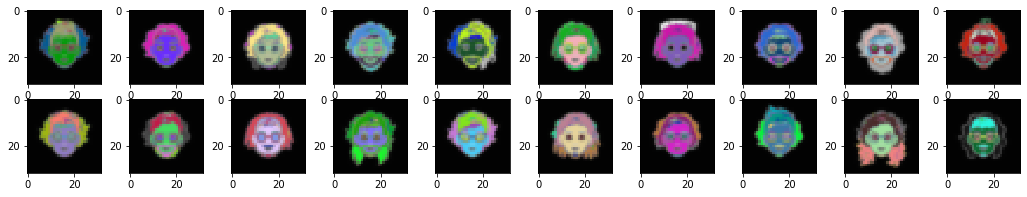


class 12


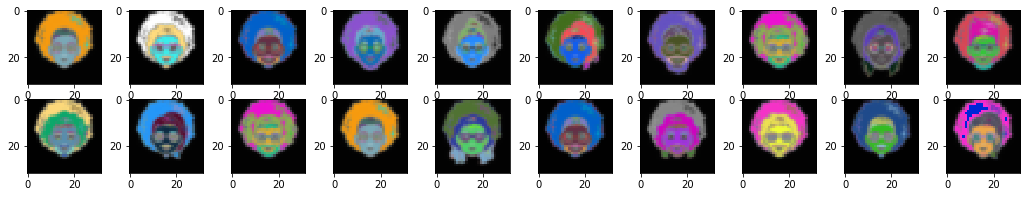


class 13


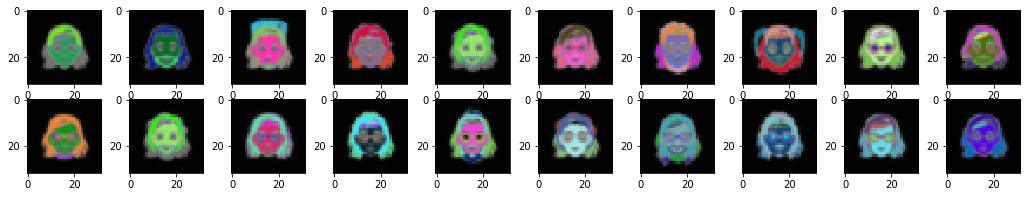


class 14


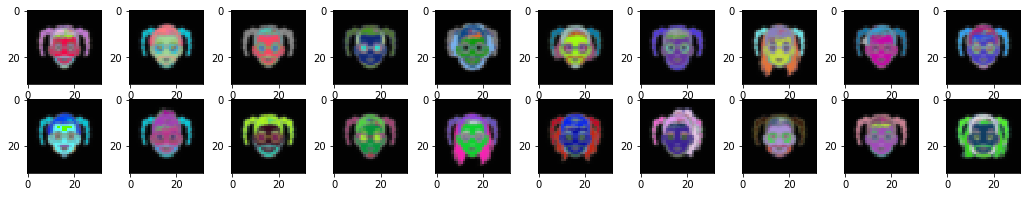


class 15


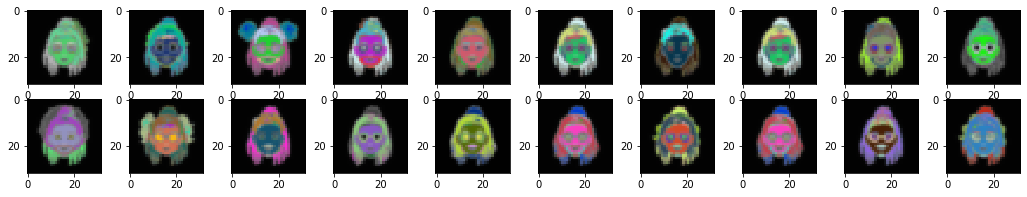


class 16


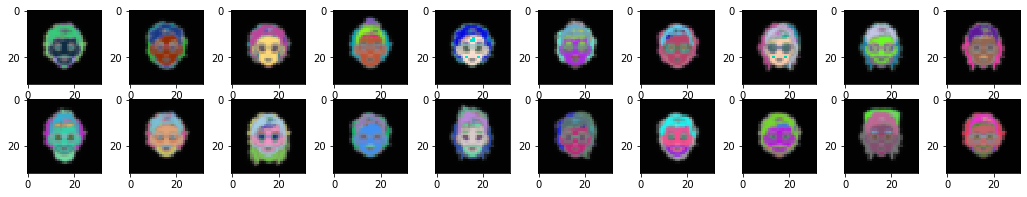


class 17


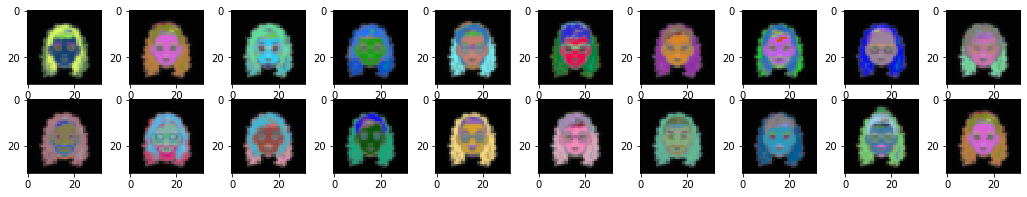


class 2


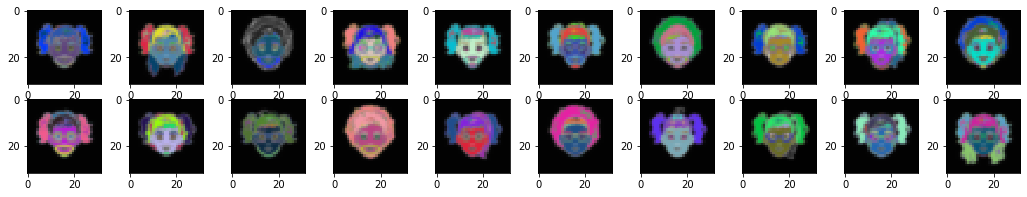


class 3


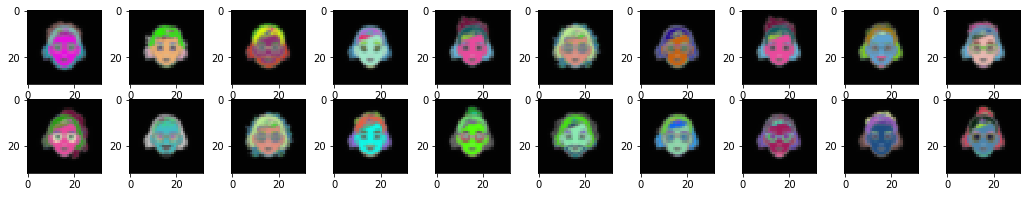


class 4


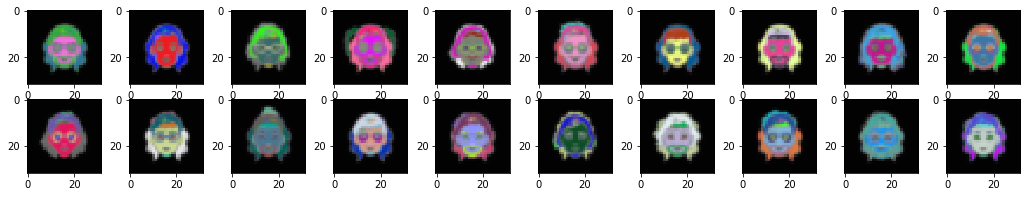


class 5


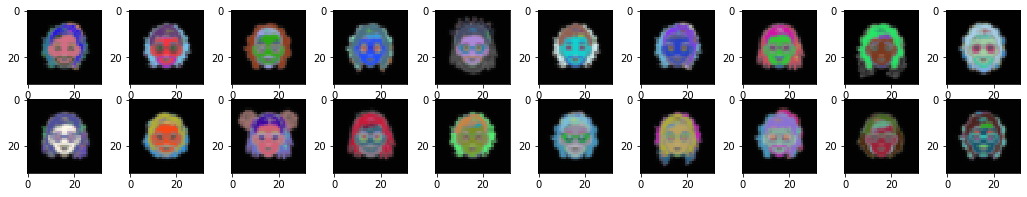


class 6


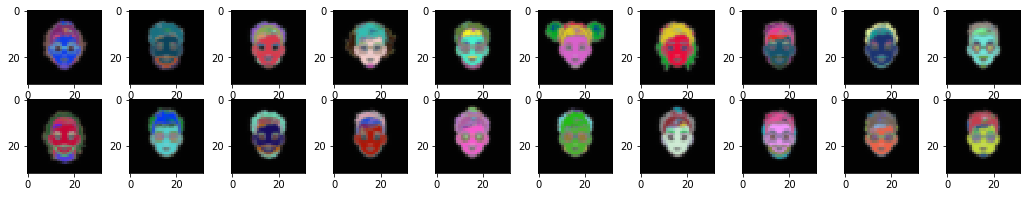


class 7


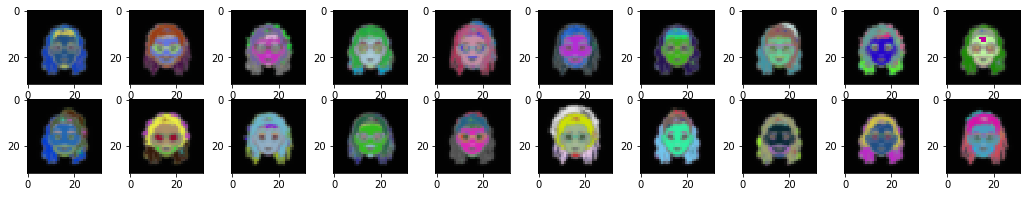


class 8


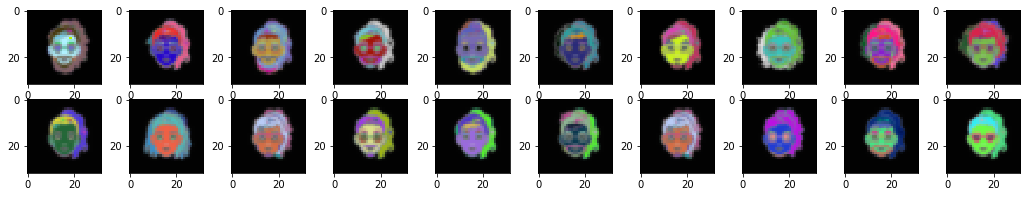


class 9


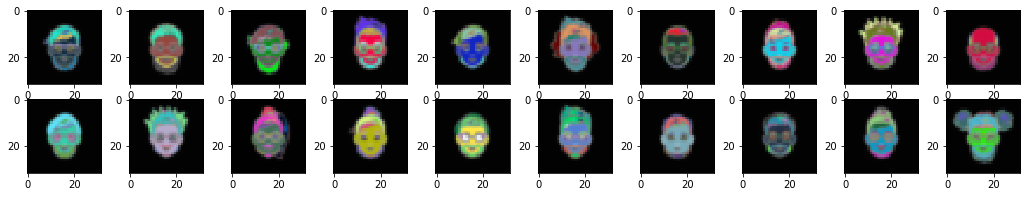

In [33]:
preview_classification(raw_data, category_labels)

The KMeans algorithms with $k=18$ appears to effectively group the avatars based on the hair style.

### Cluster based on Glasses

In [514]:
def crop_images(data, v, h):
    cropped = []
    for idx in range(data.shape[0]):
        cropped.append(data[idx][v[0]:v[1], h[0]:h[1]])
    
    return np.array(cropped)

In [521]:
glasses_cropped = crop_images(raw_data, v=(13,20), h=(10,22))
glasses_cropped.shape

(2500, 7, 12, 3)

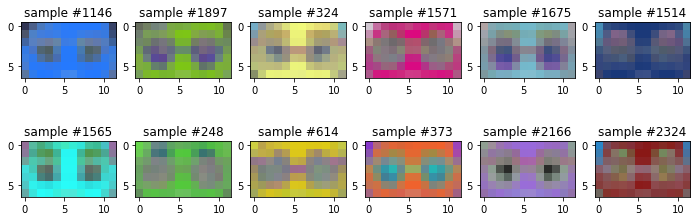

In [522]:
preview_samples(glasses_cropped, nrows=2, ncols=6, figsize=(12, 4))

In [662]:
def glasses_clustering(data):
    cropped = crop_images(data, v=(13,20), h=(10,22))
    labels = np.ones((cropped.shape[0]), dtype=np.int8)
    for idx in range(cropped.shape[0]):
        #print(cropped[idx, 1:6, 5].shape)
        mean = np.mean(cropped[idx, 2:5, 5], axis=0)
        if idx in [1146,1897,324,1571,1675,1514,1565,248,614,373,2166,2324]:
            print(idx, mean, cropped[idx][5][5], np.abs(cropped[idx][5][5] - mean))
        #print(cropped[idx, 5, 5] - mean)
        if np.any(np.abs(cropped[idx, 5, 5] - mean) < 20.0):
            labels[idx] = 0
    
    return labels

In [663]:
glasses_labels = glasses_clustering(raw_data)
glasses_labels.shape

248 [ 99.66666667 179.66666667  77.66666667] [ 83 201  60] [16.66666667 21.33333333 17.66666667]
324 [206.66666667 195.         123.        ] [235 244 123] [28.33333333 49.          0.        ]
373 [191.66666667 135.66666667  71.66666667] [239  98  45] [47.33333333 37.66666667 26.66666667]
614 [178.         145.66666667  94.66666667] [218 198  28] [40.         52.33333333 66.66666667]
1146 [ 45.66666667 122.         242.        ] [ 37 121 254] [ 8.66666667  1.         12.        ]
1514 [ 47.33333333  70.         121.66666667] [ 29  58 121] [18.33333333 12.          0.66666667]
1565 [ 40.66666667 248.33333333 243.33333333] [ 40 252 248] [0.66666667 3.66666667 4.66666667]
1571 [181.66666667  68.         118.        ] [217  10 130] [35.33333333 58.         12.        ]
1675 [125.33333333 158.66666667 172.33333333] [116 184 203] [ 9.33333333 25.33333333 30.66666667]
1897 [113.66666667 168.33333333  63.66666667] [125 198  21] [11.33333333 29.66666667 42.66666667]
2166 [157.         114.3333

(2500,)

In [623]:
glasses_edged = detect_edges(glasses_cropped, algo='laplacian')  #crop_images(edged_data, v=(13,20), h=(10,22))
glasses_edged.shape

(2500, 7, 12)

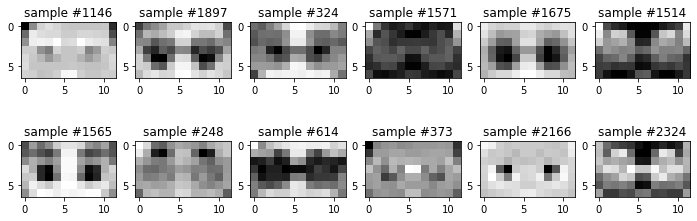

In [624]:
preview_samples(glasses_edged, nrows=2, ncols=6, figsize=(12, 4), cmap='binary_r')

In [625]:
# Flatten images
X_glasses = glasses_edged.reshape((glasses_edged.shape[0], -1))
X_glasses.shape

(2500, 84)

In [626]:
kmeans = KMeans(n_clusters=2, n_init=20, n_jobs=-1)
glasses_labels = kmeans.fit_predict(X_glasses)
glasses_labels.shape

(2500,)

Class: 0


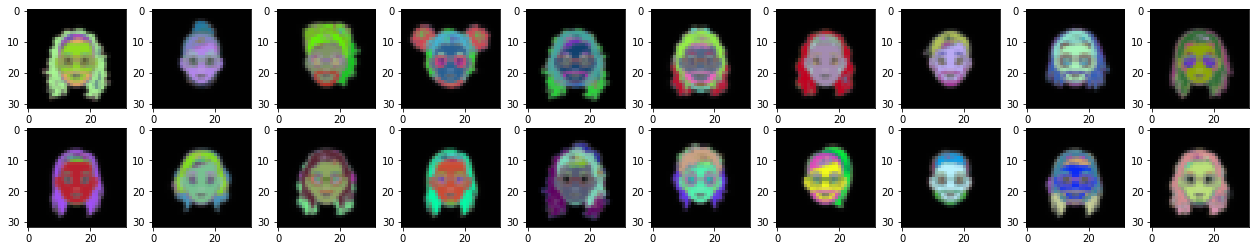


Class: 1


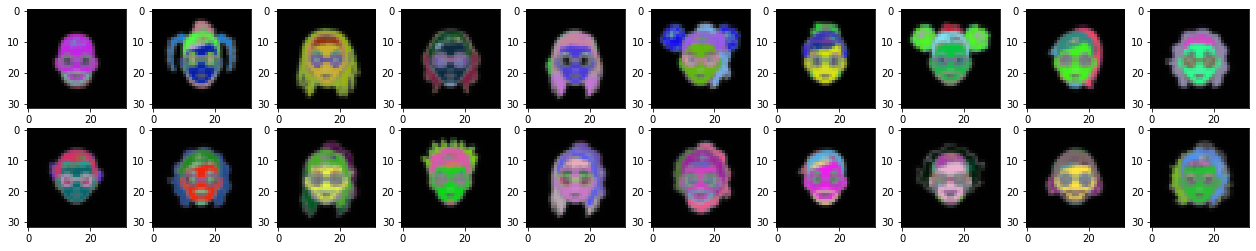

In [664]:
for label in np.unique(glasses_labels):
    y = glasses_labels[labels == label]
    x = raw_data[glasses_labels == label]

    print(f"Class: {label}")
    fig, axes = plt.subplots(nrows=2, ncols=min(10, y.shape[0]), figsize=(22, 4))
    for row in axes:
        for ax in row:
            idx = np.random.randint(x.shape[0])
            ax.imshow(x[idx])
    plt.show()
    print()

### Cluster based on Dominant Colors

Similarly, we can group the avatars based on their dominant color. We will therefore extract the dominant color in each image--excluding the darker pixels and pixels on the gray scale. We then use the RGB values as features for our KMeans clustering algorithm.

In [19]:
def extract_dominant_color(a):
    a2D = a.reshape(-1,a.shape[-1])
    keep_idx = []
    MIN = 35
    for idx in range(a2D.shape[0]):
        r = a2D[idx][0]
        g = a2D[idx][1]
        b = a2D[idx][2]
        
        if (r < MIN and g < MIN and b < MIN) or (r == g and g == b):
            pass
        else:
            keep_idx.append(idx)
    
    # Filter out darker pixel and black
    #a2D = a2D[((a2D[:,0] >= MIN) | (a2D[:,1] >= MIN) | (a2D[:,2] >= MIN)) & ((a2D[:,0] != a2D[:,1]) & (a2D[:,1] != a2D[:,2]))]
    
    a2D = a2D[keep_idx]
    col_range = (256, 256, 256) # generically : a2D.max(0)+1
    a1D = np.ravel_multi_index(a2D.T, col_range)
    return np.array(np.unravel_index(np.bincount(a1D).argmax(), col_range))
        

In [20]:
def dominant_colors(data):
    colors = np.empty((data.shape[0],3))
    for idx in range(data.shape[0]):
        color = extract_dominant_color(data[idx])
        colors[idx] = color
    return colors, np.argmax(colors, axis=1)

Color: [109 182 248]


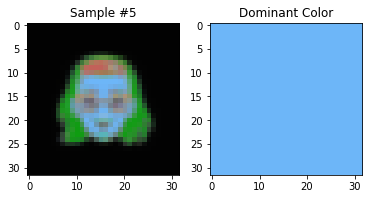

In [21]:
m_color = extract_dominant_color(raw_data[5])
plt.subplot(121)
plt.imshow(raw_data[5])
plt.title("Sample #5")
plt.subplot(122)
plt.imshow(np.full((32, 32, 3), np.full((32, 3), np.full((3), m_color))))
plt.title("Dominant Color")
print(f"Color: {m_color}")

In [22]:
main_colors, color_labels = dominant_colors(raw_data)
main_colors.shape, color_labels.shape

((7500, 3), (7500,))

In [23]:
from mpl_toolkits.mplot3d import Axes3D

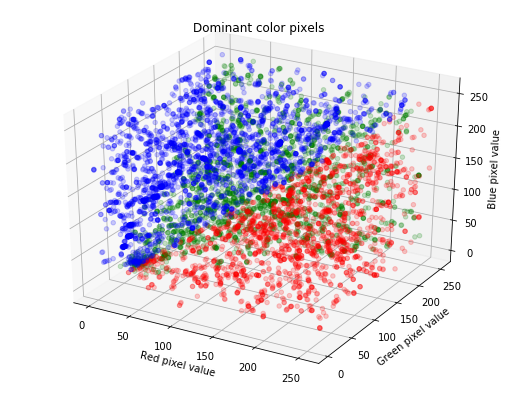

In [24]:
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d')

for m, color, c in [('o', 'Red', 0), ('o', 'Green', 1), ('o', 'Blue', 2)]:
    xs = main_colors[color_labels == c][:, 0]
    ys = main_colors[color_labels == c][:, 1]
    zs = main_colors[color_labels == c][:, 2]
    ax.scatter(xs, ys, zs, marker=m, c=color, alpha=0.2)

ax.set_xlabel('Red pixel value')
ax.set_ylabel('Green pixel value')
ax.set_zlabel('Blue pixel value')

ax.set_title('Dominant color pixels')

plt.show()

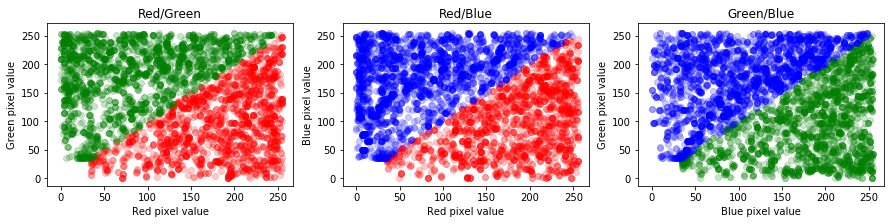

In [25]:
plt.figure(figsize=(15, 3))
plt.subplot(131)
plt.title("Red/Green")
plt.scatter(main_colors[color_labels == 0][:, 0], main_colors[color_labels == 0][:, 1], c='Red', alpha=0.2)
plt.scatter(main_colors[color_labels == 1][:, 0], main_colors[color_labels == 1][:, 1], c='Green', alpha=0.2)
plt.xlabel("Red pixel value")
plt.ylabel("Green pixel value")

plt.subplot(132)
plt.title("Red/Blue")
plt.scatter(main_colors[color_labels == 0][:, 0], main_colors[color_labels == 0][:, 2], c='Red', alpha=0.2)
plt.scatter(main_colors[color_labels == 2][:, 0], main_colors[color_labels == 2][:, 2], c='Blue', alpha=0.2)
plt.xlabel("Red pixel value")
plt.ylabel("Blue pixel value")

plt.subplot(133)
plt.title("Green/Blue")
plt.scatter(main_colors[color_labels == 1][:, 1], main_colors[color_labels == 1][:, 2], c='Green', alpha=0.2)
plt.scatter(main_colors[color_labels == 2][:, 1], main_colors[color_labels == 2][:, 2], c='Blue', alpha=0.2)
plt.xlabel("Blue pixel value")
plt.ylabel("Green pixel value")

plt.show()

We can see from the plots above that there is a clear separation between images with dominant color in each of the RGB colors. The simple appears to give satisfying results. There is no need for a ML model such as KMeans.

In [31]:
def color_clustering(data):
    colors_map = {0: 'red', 1: 'green', 2: 'blue'}
    colors, color_labels = dominant_colors(raw_data)
    return np.array(["avatar " + colors_map[y] for y in color_labels])

0


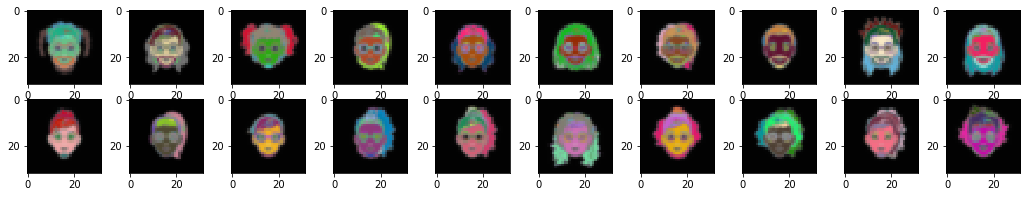


1


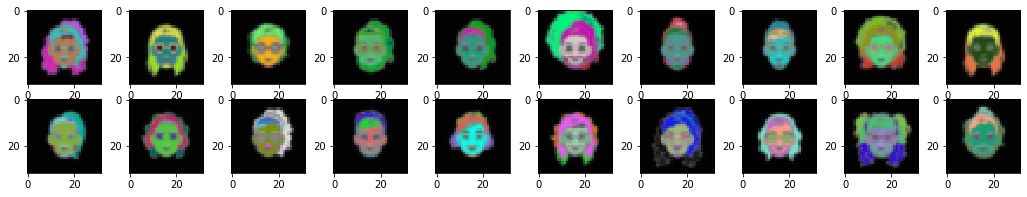


2


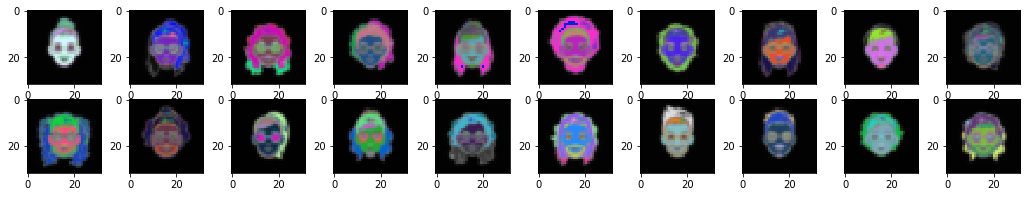

In [27]:
preview_classification(raw_data, color_labels)

# Export features

In [28]:
def export_features(data, ids):
    df = pd.DataFrame(ids, columns=['Id'])
    # Cluster based on shape
    df['Profile Image Avatar (18)'] = shape_clustering(data, 18)
    df['Profile Image Avatar (13)'] = shape_clustering(data, 13)
    df['Profile Image Avatar (10)'] = shape_clustering(data, 10)
    
    # Cluster based on dominant color
    df['Profile Image Dominant Color'] = color_clustering(data)
    
    return df

In [78]:
profile_im_df = export_features(raw_data, ids)
profile_im_df.head()

,Id,Profile Image Avatar (18),Profile Image Avatar (13),Profile Image Avatar (10),Profile Image Dominant Color
0,00406GAJ0LMI2NDM,class 3,class 10,class 7,avatar red
1,01250ADN9H8O9CLH,class 15,class 3,class 5,avatar red
2,01D40L6DEB1N33TT,class 16,class 7,class 1,avatar red
3,01HG044MB40QIQ3T,class 6,class 9,class 7,avatar blue
4,02CBLI3E9KQGKNFR,class 3,class 8,class 7,avatar red


# Colors

In [79]:
train_df = pd.read_csv('./data/test.csv')

In [36]:
def hex2rgb(hex_code):
    return np.array([int(hex_code[i:i+2], 16) for i in (0, 2, 4)])

In [37]:
def hex2dominantChannel(hex_code):
    colors_map = {0: 'red', 1: 'green', 2: 'blue'}
    rgb = hex2rgb(hex_code)
    y = np.argmax(rgb)
    return colors_map[y]

In [80]:
colors_df = train_df[['Id','Profile Text Color','Profile Theme Color','Profile Page Color']]

In [81]:
cols = ['Profile Image Avatar (10)', 'Profile Image Avatar (13)', 
        'Profile Image Avatar (18)', 'Profile Image Dominant Color']
colors_df[cols] = profile_im_df[cols]
colors_df['Num of Profile Likes'] = train_df['Num of Profile Likes']

C:\Users\ngoum\anaconda3\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [82]:
colors_df['Profile Text Color'].fillna(colors_df['Profile Text Color'].mode()[0], inplace=True)
colors_df['Profile Theme Color'].fillna(colors_df['Profile Text Color'].mode()[0], inplace=True)
colors_df['Profile Page Color'].fillna(colors_df['Profile Text Color'].mode()[0], inplace=True)

C:\Users\ngoum\anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [83]:
colors_df['Profile Text Color'] = colors_df['Profile Text Color'].apply(lambda x: "text " + hex2dominantChannel(x))
colors_df['Profile Theme Color'] = colors_df['Profile Theme Color'].apply(lambda x: "theme " + hex2dominantChannel(x))
colors_df['Profile Page Color'] = colors_df['Profile Page Color'].apply(lambda x: "page " + hex2dominantChannel(x))

C:\Users\ngoum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\ngoum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\ngoum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [84]:
colors_df.head()

,Id,Profile Text Color,Profile Theme Color,Profile Page Color,Profile Image Avatar (10),Profile Image Avatar (13),Profile Image Avatar (18),Profile Image Dominant Color
0,49I3SOKLI2CMNGP4,text red,theme red,page red,class 7,class 10,class 3,avatar red
1,727IRIR59A3P88LK,text red,theme blue,page red,class 5,class 3,class 15,avatar red
2,LN95SD15SRPCEE8F,text red,theme red,page red,class 1,class 7,class 16,avatar red
3,TB11I7F0PN033D4T,text blue,theme blue,page green,class 7,class 9,class 6,avatar blue
4,32PSGCK5PATHMR07,text red,theme red,page blue,class 7,class 8,class 3,avatar red


# Analysis

In [43]:
def plot_bar(colname, title=None, xlabel='Dominant Color', figsize=(7,4)):
    title = colname if title is None else title
    
    x = np.sort(np.unique(colors_df[colname]))
    y = np.zeros((x.shape[0]))
    for idx in range(x.shape[0]):
        y[idx] = colors_df['Num of Profile Likes'][colors_df[colname] == x[idx]].mean()
                  
    plt.figure(figsize=figsize)
    plt.bar(x, y)
    plt.xlabel(xlabel)
    plt.ylabel('Count')
    plt.title(f'Avg Num of Likes per {title}')

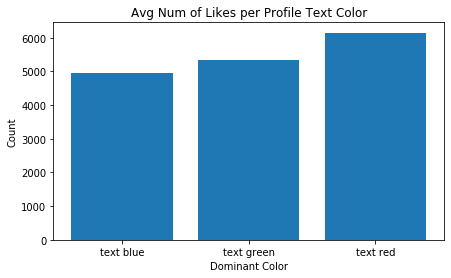

In [44]:
plot_bar('Profile Text Color')

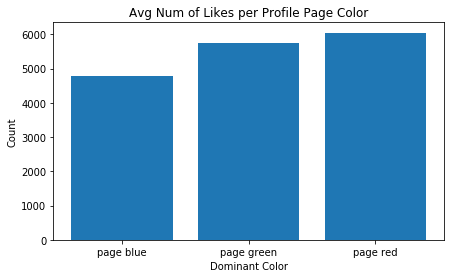

In [45]:
plot_bar('Profile Page Color')

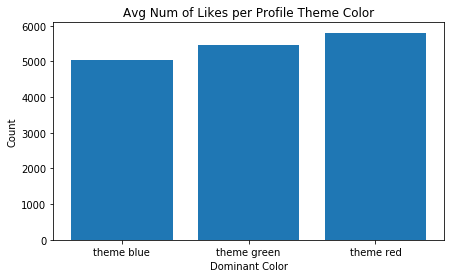

In [46]:
plot_bar('Profile Theme Color')

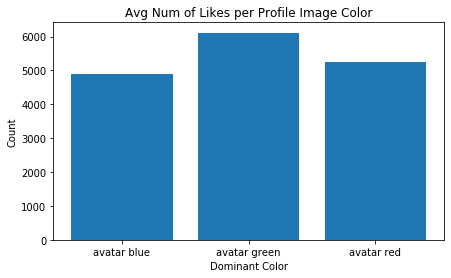

In [47]:
plot_bar('Profile Image Dominant Color', title='Profile Image Color')

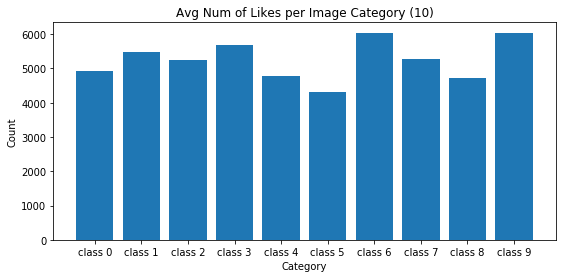

In [48]:
plot_bar('Profile Image Avatar (10)', title='Image Category (10)', xlabel='Category', figsize=(9,4))

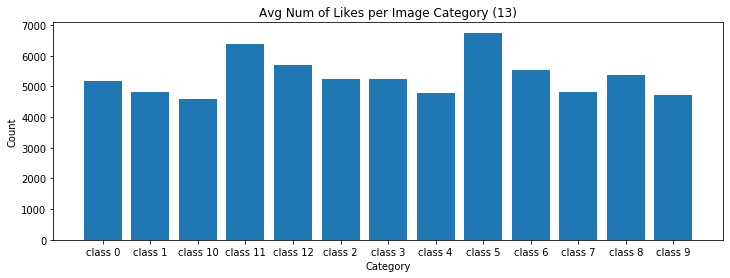

In [49]:
plot_bar('Profile Image Avatar (13)', title='Image Category (13)', xlabel='Category', figsize=(12,4))

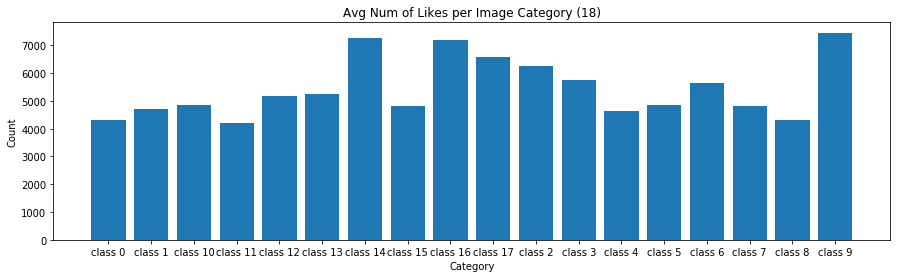

In [50]:
plot_bar('Profile Image Avatar (18)', title='Image Category (18)', xlabel='Category', figsize=(15,4))

In [51]:
def plot_scatter(col1, col2, x1label=None, x2label=None, title="Avg Number of Profile Likes", figsize=(7,4)):
    x1label = col1 if x1label is None else x1label
    x2label = col2 if x2label is None else x2label
    
    x1 = np.unique(colors_df[col1])
    x2 = np.unique(colors_df[col2])
    x = np.empty((x1.shape[0] * x2.shape[0], 2), dtype=np.object)
    y = np.zeros((x.shape[0]))
    
    for i in range(x1.shape[0]):
        for j in range(x2.shape[0]):
            x[i*3 + j][0] = x1[i]
            x[i*3 + j][1] = x2[j]
            y[i*3 + j] = colors_df['Num of Profile Likes'][(colors_df[col1] == x1[i]) & (colors_df[col2] == x2[j])].mean()
    
    y[np.isnan(y)] = 0.0
    
    plt.figure(figsize=figsize)
    plt.scatter(x[:,0], x[:,1], s=(y*.05), c=y, alpha=0.5)
    plt.xlabel(x1label)
    plt.ylabel(x2label)
    plt.xticks(np.arange(0, x1.shape[0], 1))
    plt.yticks(np.arange(0, x2.shape[0], 1))
    plt.title(title)

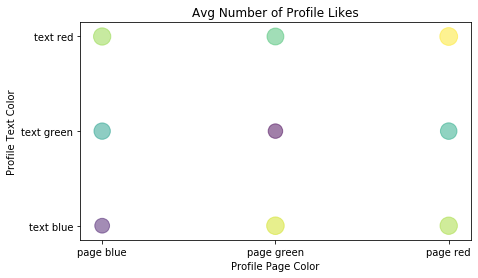

In [52]:
plot_scatter('Profile Page Color', 'Profile Text Color', figsize=(7,4))

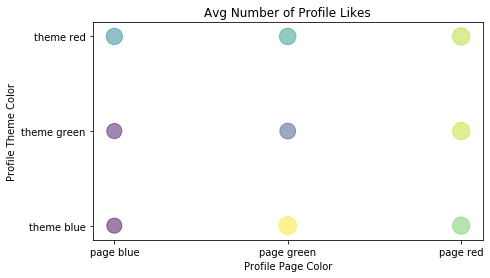

In [53]:
plot_scatter('Profile Page Color', 'Profile Theme Color', figsize=(7,4))

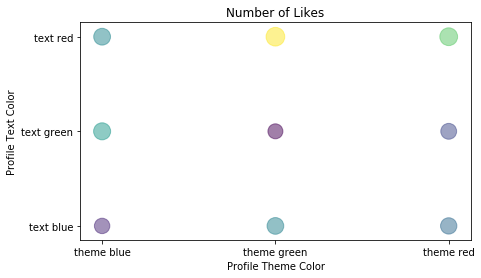

In [54]:
plot_scatter('Profile Theme Color', 'Profile Text Color', title="Number of Likes", figsize=(7,4))

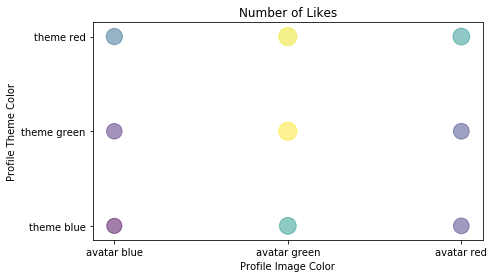

In [55]:
plot_scatter('Profile Image Dominant Color', 'Profile Theme Color', x1label = "Profile Image Color", title="Number of Likes", figsize=(7,4))

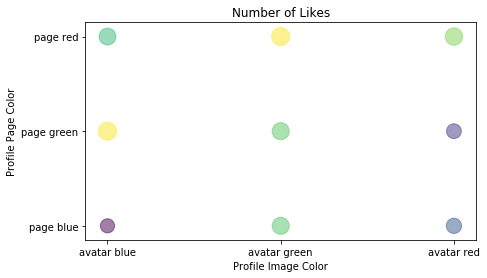

In [56]:
plot_scatter('Profile Image Dominant Color', 'Profile Page Color', x1label = "Profile Image Color", title="Number of Likes", figsize=(7,4))

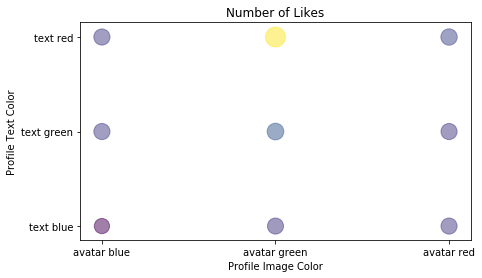

In [57]:
plot_scatter('Profile Image Dominant Color', 'Profile Text Color', x1label = "Profile Image Color", title="Number of Likes", figsize=(7,4))

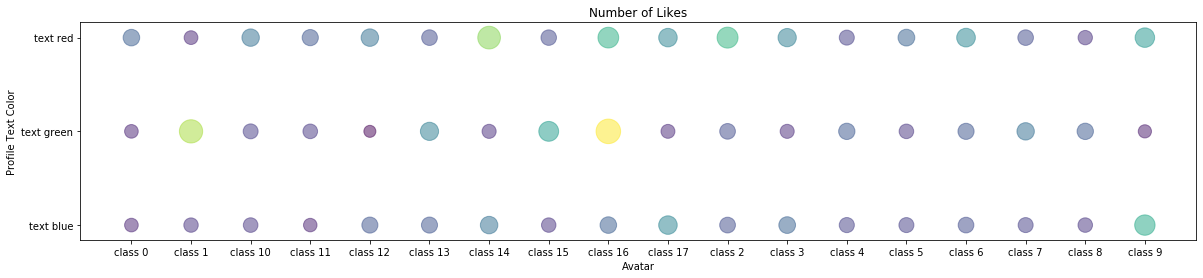

In [58]:
plot_scatter('Profile Image Avatar (18)', 'Profile Text Color', x1label = "Avatar", title="Number of Likes", figsize=(20,4))

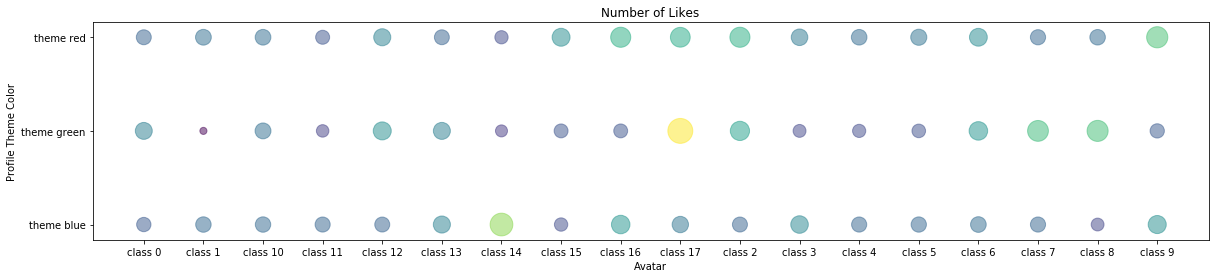

In [59]:
plot_scatter('Profile Image Avatar (18)', 'Profile Theme Color', x1label = "Avatar", title="Number of Likes", figsize=(20,4))

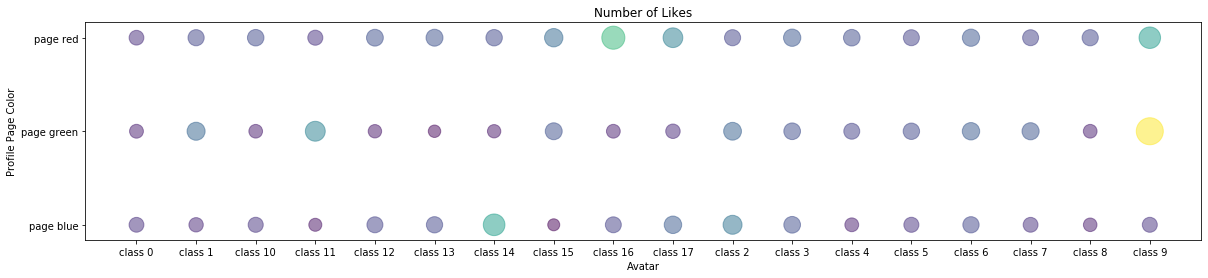

In [60]:
plot_scatter('Profile Image Avatar (18)', 'Profile Page Color', x1label = "Avatar", title="Number of Likes", figsize=(20,4))

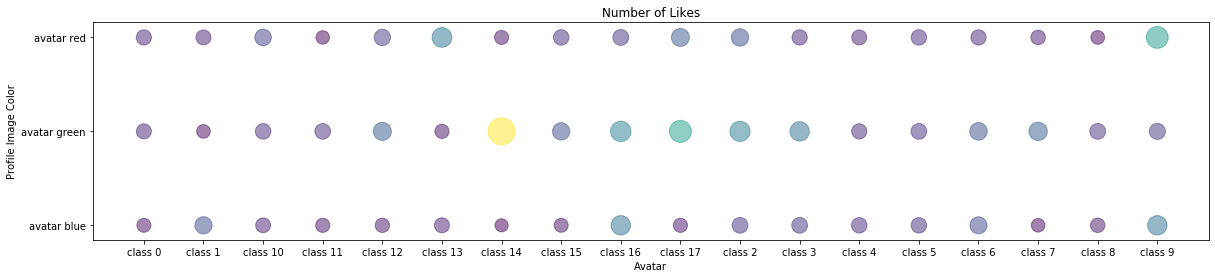

In [62]:
plot_scatter('Profile Image Avatar (18)', 'Profile Image Dominant Color', x1label = "Avatar", x2label="Profile Image Color", title="Number of Likes", figsize=(20,4))

# Export to CSV

In [85]:
colors_df.head()

,Id,Profile Text Color,Profile Theme Color,Profile Page Color,Profile Image Avatar (10),Profile Image Avatar (13),Profile Image Avatar (18),Profile Image Dominant Color
0,49I3SOKLI2CMNGP4,text red,theme red,page red,class 7,class 10,class 3,avatar red
1,727IRIR59A3P88LK,text red,theme blue,page red,class 5,class 3,class 15,avatar red
2,LN95SD15SRPCEE8F,text red,theme red,page red,class 1,class 7,class 16,avatar red
3,TB11I7F0PN033D4T,text blue,theme blue,page green,class 7,class 9,class 6,avatar blue
4,32PSGCK5PATHMR07,text red,theme red,page blue,class 7,class 8,class 3,avatar red


In [86]:
df = colors_df[['Id','Profile Image Avatar (10)','Profile Image Avatar (13)','Profile Image Avatar (18)','Profile Image Dominant Color']]
df.head()

,Id,Profile Image Avatar (10),Profile Image Avatar (13),Profile Image Avatar (18),Profile Image Dominant Color
0,49I3SOKLI2CMNGP4,class 7,class 10,class 3,avatar red
1,727IRIR59A3P88LK,class 5,class 3,class 15,avatar red
2,LN95SD15SRPCEE8F,class 1,class 7,class 16,avatar red
3,TB11I7F0PN033D4T,class 7,class 9,class 6,avatar blue
4,32PSGCK5PATHMR07,class 7,class 8,class 3,avatar red


In [87]:
df.to_csv('./data/train_profile_images_data.csv', index=False)